In [1]:
import warnings
warnings.filterwarnings('ignore') # 実行に影響のない　warninig　を非表示にします. 非推奨.

# Chapter 10: PytorchによるVAE
ここではpytorchによるVAEの実装を行います．\
変分推論についてはPRMLの下巻で説明があるので理論が気になる方はそちらを確認するのをお勧めします．\
実装に関して引用したblog（正直これをみても良い）➡️ https://www.sambaiz.net/article/212/ \
理論を無視して使い方だけを学ぶことはあまりお勧めできませんが，卒論などに際して**どの様な技術があるのか？**を知っておくと手をつけやすいとも思います． \


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
%matplotlib inline
print(torch.__version__)

1.9.1


データセットの準備

In [3]:
#データの前処理を行うクラスインスタンス
transform = transforms.Compose(
    [transforms.Resize((16, 16)),
     transforms.ToTensor(),
     #transforms.Normalize((0.5, ), (0.5, ))
    ])

batch_size = 100

#使用するtrainデータセット
trainset = torchvision.datasets.MNIST(root='./data', 
                                        train=True,
                                        download=True,
                                        transform=transform)
#データ分割
#trainset, _ = torch.utils.data.random_split(trainset, [10000, len(trainset)-10000])
print(len(trainset))

#trainデータをbatchごとに逐次的に取り出してくれるクラスインスタンス
trainloader = torch.utils.data.DataLoader(trainset,
                                            batch_size=batch_size,
                                            shuffle=True)

60000


## VAEのモデル構築
VAEのモデルは大きく分けて入力を特徴量空間上に写像する**encoder**と特徴量空間上で表現されたベクトルを受け取って入力の再構成を行う**decoder**で表現されます．\
イメージとしてはこんな感じ．　（うまく相手に伝わる様な言葉を学習するデコーダーくんと相手の言葉から相手の意図やイメージをより精密に再現する様に学習するデコーダーくん）
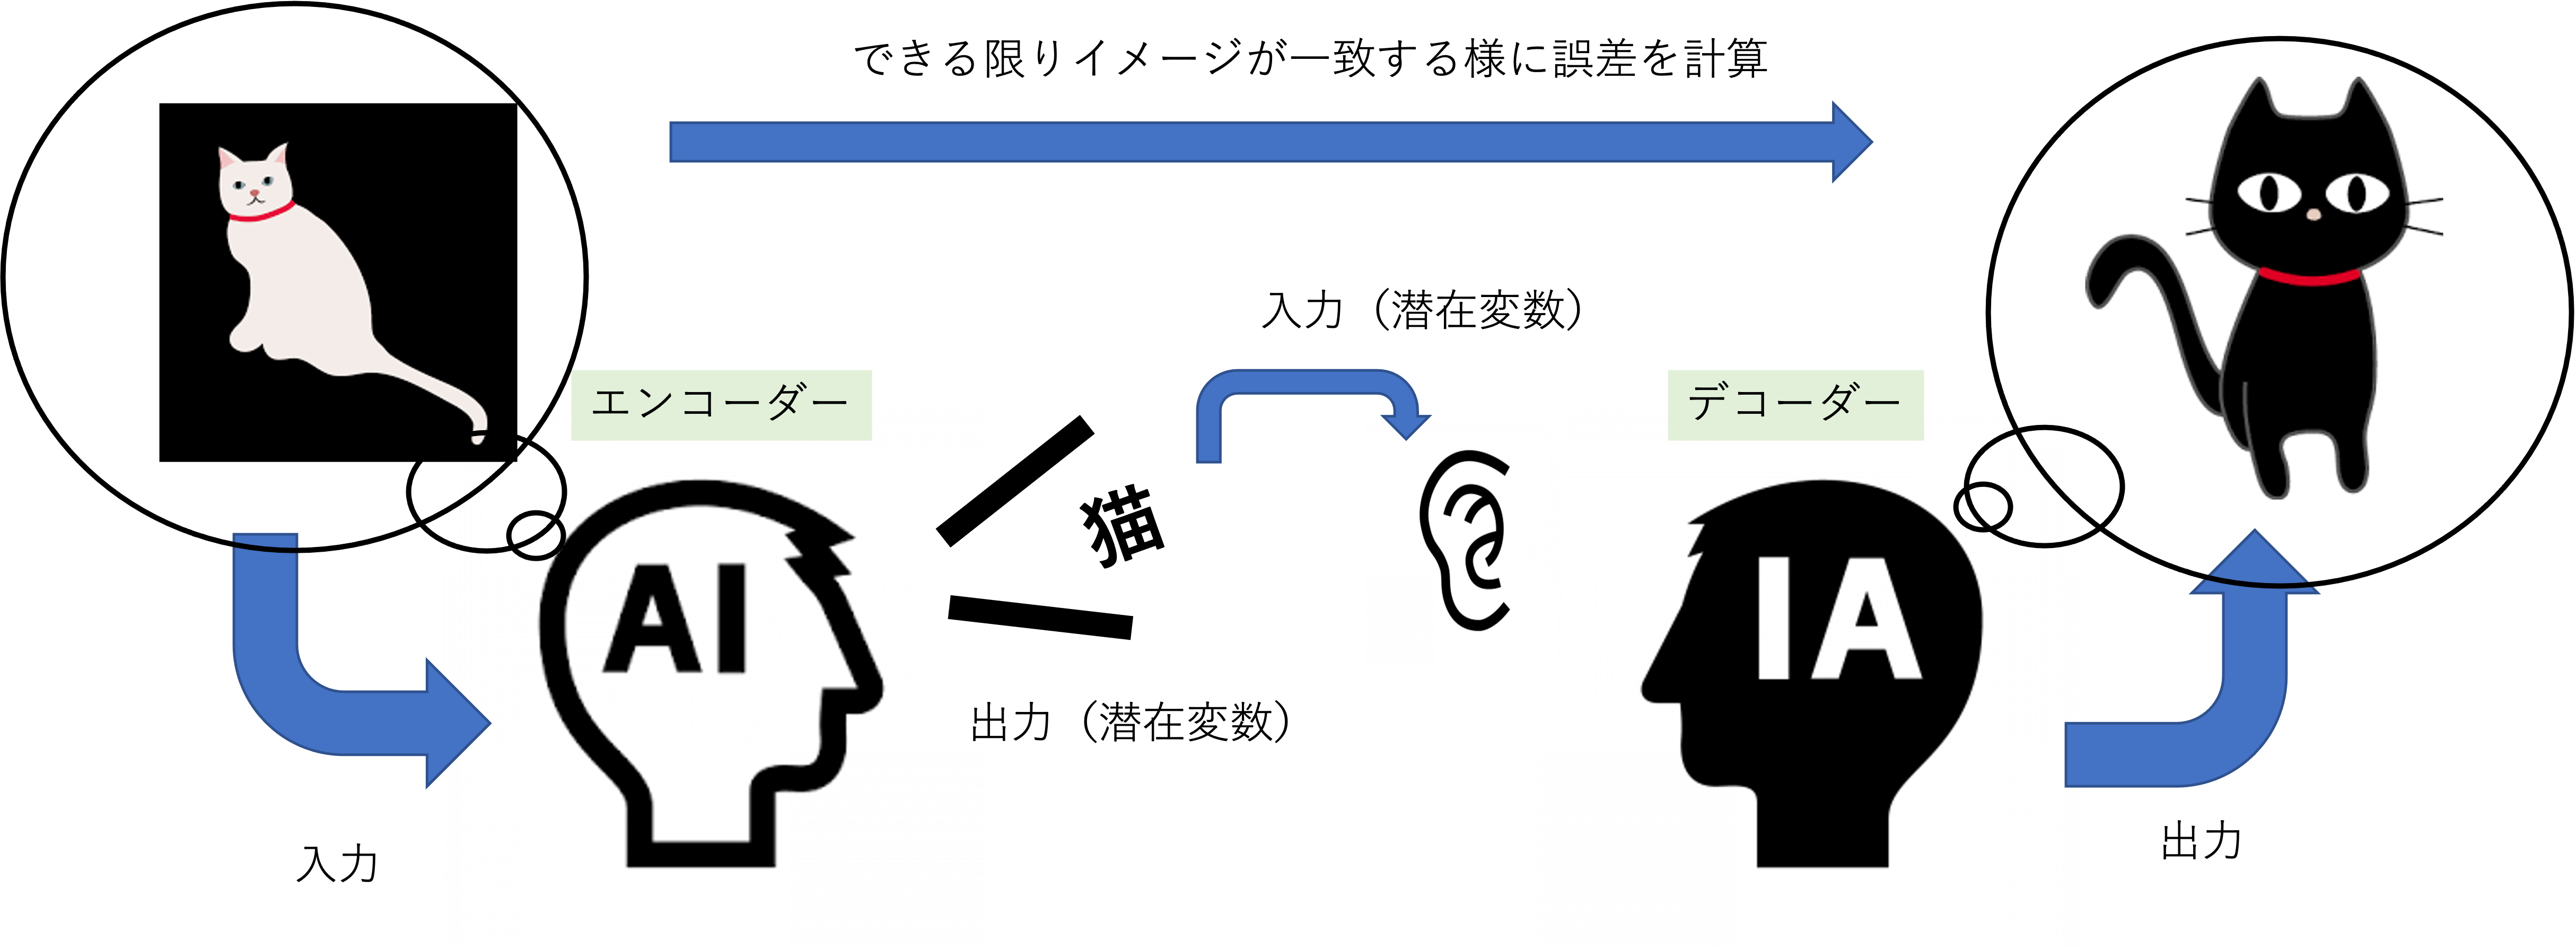

In [4]:
class VAE(torch.nn.Module):
    def __init__(self, z_dim, n_input=256):
        super(VAE, self).__init__()
        self.n_input = n_input
        self.dense_enc1 = torch.nn.Linear(self.n_input, 128)
        self.dense_enc2 = torch.nn.Linear(128, 64)
        self.dense_encmean = torch.nn.Linear(64, z_dim)
        self.dense_encvar = torch.nn.Linear(64, z_dim)
        self.dense_dec1 = torch.nn.Linear(z_dim, 64)
        self.dense_dec2 = torch.nn.Linear(64, 128)
        self.dense_dec3 = torch.nn.Linear(128, self.n_input)
    
    def _encoder(self, x):
        x = F.relu(self.dense_enc1(x))
        x = F.relu(self.dense_enc2(x))
        mean = F.sigmoid(self.dense_encmean(x))
        #mean = self.dense_encmean(x)
        #この後の確認作業上sigmoidに通しておくと便利なだけで絶対必要ではない
        var = F.softplus(self.dense_encvar(x))
        return mean, var
    
    def _sample_z(self, mean, var):
        epsilon = torch.randn(mean.shape)
        return mean + torch.sqrt(var) * epsilon

    def _decoder(self, z):
        x = F.relu(self.dense_dec1(z))
        x = F.relu(self.dense_dec2(x))
        x = F.sigmoid(self.dense_dec3(x))
        return x

    def forward(self, x):
        x = x.view(-1, self.n_input)
        mean, var = self._encoder(x)
        z = self._sample_z(mean, var)
        x = self._decoder(z)
        return x, z
    
    def loss(self, x):
        x = x.view(-1, self.n_input)
        mean, var = self._encoder(x)
        KL = -0.5 * torch.mean(torch.sum(1 + torch.log(var) - mean**2 - var))
        z = self._sample_z(mean, var)
        y = self._decoder(z)
        reconstruction = torch.mean(torch.sum(x * torch.log(y) + (1 - x) * torch.log(1 - y)))
        lower_bound = [-KL, reconstruction]
        return -sum(lower_bound)

なぜ潜在変数空間からサンプリングを行うのか？なぜ単純な二乗和誤差を使わないのか？などについて調べると良いかも？
## 学習

In [5]:
hidden_size = 20
model = VAE(hidden_size)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#最適化手法の設定
#optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
model.train()
for i in range(20):
    losses = []
    for x, t in trainloader:
        model.zero_grad()
        y = model(x)
        loss = model.loss(x)
        loss.backward()
        optimizer.step()
        losses.append(loss.cpu().detach().numpy())
    print("EPOCH: {} loss: {}".format(i, np.average(losses)))

EPOCH: 0 loss: 7212.74853515625
EPOCH: 1 loss: 6688.294921875
EPOCH: 2 loss: 6607.666015625
EPOCH: 3 loss: 6564.3291015625
EPOCH: 4 loss: 6510.4853515625
EPOCH: 5 loss: 6442.0341796875
EPOCH: 6 loss: 6369.98095703125
EPOCH: 7 loss: 6309.20068359375
EPOCH: 8 loss: 6266.0234375
EPOCH: 9 loss: 6222.8173828125
EPOCH: 10 loss: 6169.33935546875
EPOCH: 11 loss: 6134.0
EPOCH: 12 loss: 6112.54150390625
EPOCH: 13 loss: 6093.658203125
EPOCH: 14 loss: 6076.998046875
EPOCH: 15 loss: 6061.93505859375
EPOCH: 16 loss: 6048.16064453125
EPOCH: 17 loss: 6036.1904296875
EPOCH: 18 loss: 6025.2939453125
EPOCH: 19 loss: 6011.3876953125


## 実際に生成してみる（入力サンプルから）
入力を再構成できているのか？を確認

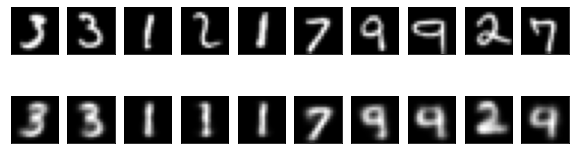

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(10, 3))

model.eval()
zs = []
for x, t in trainloader:
    # original
    for i, im in enumerate(x.view(-1, 16, 16).detach().numpy()[:10]):
        ax = fig.add_subplot(2, 10, i+1, xticks=[], yticks=[])
        ax.imshow(im, 'gray')
    # generate from x
    y, z = model(x)
    zs.append(z)
    y = y.view(-1, 16, 16)
    for i, im in enumerate(y.cpu().detach().numpy()[:10]):
        ax = fig.add_subplot(2, 10, i+11, xticks=[], yticks=[])
        ax.imshow(im, 'gray')
    break

## 実際に生成してみる（潜在変数から）
潜在変数空間を2次元に切ってその断面をデコーダーの入力にしてみる．（徐々にいろんな数字に変化していれば成功）

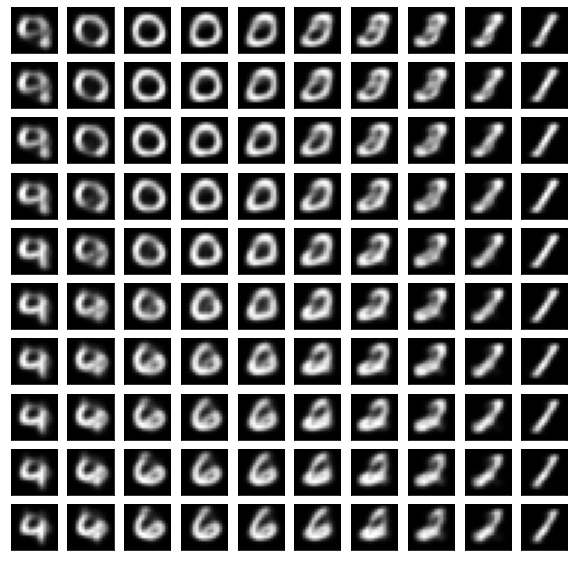

In [7]:
# generate from z
fig = plt.figure(figsize=(10, 10))
for i in range(10):
    array_i = i*0.1*torch.ones(10, 1)
    z1to0_ = torch.cat([torch.arange(0, 1, 0.1).view(10, 1), array_i], dim=1)
    z1to0 = torch.clone(z1to0_)
    if hidden_size>2:
        for j in range(hidden_size//2-1):
            z1to0 = torch.cat([z1to0_, z1to0], dim=1)
    y2 = model._decoder(z1to0).view(-1, 16, 16)
    for j, im in enumerate(y2.cpu().detach().numpy()):
        ax = fig.add_subplot(10, 10, j+10*i+1, xticks=[], yticks=[])
        ax.imshow(im, 'gray')

（[chapter09](Chapter09.ipynb)を参考にエンコーダ部分を利用して転移学習をしてみても面白いかも？）